In [2]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/CSE331_ML_Project/khu-machine-learning-competition.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: valid/truck/n03632852_1173.png  
  inflating: valid/truck/n03632852_11766.png  
  inflating: valid/truck/n03632852_11887.png  
  inflating: valid/truck/n03632852_1191.png  
  inflating: valid/truck/n03632852_1192.png  
  inflating: valid/truck/n03632852_1195.png  
  inflating: valid/truck/n03632852_1207.png  
  inflating: valid/truck/n03632852_12128.png  
  inflating: valid/truck/n03632852_1214.png  
  inflating: valid/truck/n03632852_1237.png  
  inflating: valid/truck/n03632852_1248.png  
  inflating: valid/truck/n03632852_1261.png  
  inflating: valid/truck/n03632852_1264.png  
  inflating: valid/truck/n03632852_1292.png  
  inflating: valid/truck/n03632852_1313.png  
  inflating: valid/truck/n03632852_1319.png  
  inflating: valid/truck/n03632852_13311.png  
  inflating: valid/truck/n03632852_1355.png  
  inflating: valid/truck/n03632852_13648.png  
  inflating: valid/truck/n03632852_13730.png  
  inflating: valid/truck/n03632852_138

Streaming output truncated to the last 5000 lines.
Epoch: [78][ 40/352]	Time  0.137 ( 0.168)	Data  0.000 ( 0.016)	Loss 2.2998e+00 (2.3074e+00)	Acc@1  12.11 ( 10.01)	Acc@5  52.34 ( 50.56)
Epoch: [78][ 50/352]	Time  0.130 ( 0.165)	Data  0.000 ( 0.013)	Loss 2.3011e+00 (2.3072e+00)	Acc@1  13.67 (  9.91)	Acc@5  51.17 ( 50.39)
Epoch: [78][ 60/352]	Time  0.152 ( 0.163)	Data  0.000 ( 0.011)	Loss 2.3135e+00 (2.3068e+00)	Acc@1   6.64 (  9.96)	Acc@5  49.61 ( 50.53)
Epoch: [78][ 70/352]	Time  0.139 ( 0.161)	Data  0.000 ( 0.010)	Loss 2.2953e+00 (2.3069e+00)	Acc@1  13.28 (  9.98)	Acc@5  55.08 ( 50.56)
Epoch: [78][ 80/352]	Time  0.149 ( 0.159)	Data  0.001 ( 0.009)	Loss 2.3073e+00 (2.3070e+00)	Acc@1   8.20 (  9.97)	Acc@5  47.27 ( 50.47)
Epoch: [78][ 90/352]	Time  0.139 ( 0.158)	Data  0.003 ( 0.008)	Loss 2.3180e+00 (2.3068e+00)	Acc@1   9.38 ( 10.02)	Acc@5  50.39 ( 50.44)
Epoch: [78][100/352]	Time  0.141 ( 0.157)	Data  0.000 ( 0.007)	Loss 2.3158e+00 (2.3068e+00)	Acc@1   7.42 ( 10.07)	Acc@5  46.48 ( 50.4

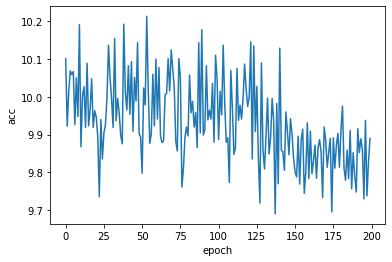

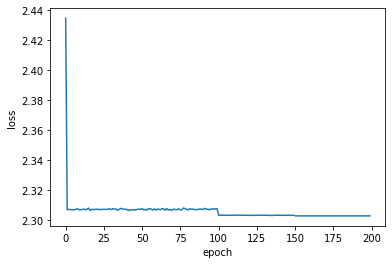

Make an evaluation csv file for kaggle submission...
Done!!


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


history={'val_acc':[],'val_loss':[]}


class IdentityPadding(nn.Module):
	def __init__(self, in_channels, out_channels, stride):
		super(IdentityPadding, self).__init__()
		
		self.pooling = nn.MaxPool2d(1, stride=stride)
		self.add_channels = out_channels - in_channels
    
	def forward(self, x):
		out = F.pad(x, (0, 0, 0, 0, 0, self.add_channels))
		out = self.pooling(out)
		return out
	
	
class ResidualBlock(nn.Module):
	def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
		super(ResidualBlock, self).__init__()
		self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
			                   stride=stride, padding=1, bias=False) 
		self.bn1 = nn.BatchNorm2d(out_channels)
		self.relu = nn.ReLU(inplace=True)

		self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
			                   stride=1, padding=1, bias=False) 
		self.bn2 = nn.BatchNorm2d(out_channels)
		self.stride = stride
		
		if down_sample:
			self.down_sample = IdentityPadding(in_channels, out_channels, stride)
		else:
			self.down_sample = None


	def forward(self, x):
		shortcut = x

		out = self.conv1(x)
		out = self.bn1(out)
		out = self.relu(out)

		out = self.conv2(out)
		out = self.bn2(out)

		if self.down_sample is not None:
			shortcut = self.down_sample(x)

		out += shortcut
		out = self.relu(out)
		return out


class ResNet(nn.Module):
	def __init__(self, num_layers, block, num_classes=10):
		super(ResNet, self).__init__()
		self.num_layers = num_layers
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, 
							   stride=1, padding=1, bias=False)
		self.bn1 = nn.BatchNorm2d(16)
		self.relu = nn.ReLU(inplace=True)
		
		# feature map size = 32x32x16
		self.layers_2n = self.get_layers(block, 16, 16, stride=1)
		# feature map size = 16x16x32
		self.layers_4n = self.get_layers(block, 16, 32, stride=2)
		# feature map size = 8x8x64
		self.layers_6n = self.get_layers(block, 32, 64, stride=2)

		# output layers
		self.avg_pool = nn.AvgPool2d(8, stride=1)
		self.fc_out = nn.Linear(64, num_classes)
		
		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', 
					                    nonlinearity='relu')
			elif isinstance(m, nn.BatchNorm2d):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)
	
	def get_layers(self, block, in_channels, out_channels, stride):
		if stride == 2:
			down_sample = True
		else:
			down_sample = False
		
		layers_list = nn.ModuleList(
			[block(in_channels, out_channels, stride, down_sample)])
			
		for _ in range(self.num_layers - 1):
			layers_list.append(block(out_channels, out_channels))

		return nn.Sequential(*layers_list)
		
	def forward(self, x):
		x = self.conv1(x)
		x = self.bn1(x)
		x = self.relu(x)

		x = self.layers_2n(x)
		x = self.layers_4n(x)
		x = self.layers_6n(x)

		x = self.avg_pool(x)
		x = x.view(x.size(0), -1)
		x = self.fc_out(x)
		return x


def resnet():
	block = ResidualBlock
	# total number of layers if 6n + 2. if n is 5 then the depth of network is 32.
	model = ResNet(7, block) #Resnet 56
	return model

class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
        
SAVEPATH = '/content/drive/My Drive/CSE331_ML_Project/'
WEIGHTDECAY = 5e-4
MOMENTUM = 0.9
BATCHSIZE = 256
LR = 0.5
EPOCHS = 200
PRINTFREQ = 10


def main():
    model = resnet()
    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.SGD(model.parameters(), lr=LR,
                                momentum=MOMENTUM, weight_decay=WEIGHTDECAY,
                                )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100, 150],
                                                     gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda()
    criterion = criterion.cuda()

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")
    if int(pytorch_total_params) > 2000000:
        print('Your model has the number of parameters more than 2 millions..')
        return

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    train_dataset = torchvision.datasets.ImageFolder(
        './train', transform=train_transform)
    train_loader = DataLoader(train_dataset,
                              batch_size=BATCHSIZE, shuffle=True,
                              num_workers=4, pin_memory=True)
    
    val_dataset = torchvision.datasets.ImageFolder('./valid', transform=valid_transform)

    last_top1_acc = 0

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))

        # train for one epoch
        start_time = time.time()
        last_top1_acc = train(train_loader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()
        
        # Save model each epoch
        torch.save(model.state_dict(), SAVEPATH+'model_weight.pth')
    
    print(f"Last Top-1 Accuracy: {last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")
    print(range(EPOCHS))
    print(history['val_acc'])
    plt.plot(range(EPOCHS),history['val_acc'])
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.show()
    plt.plot(range(EPOCHS),history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()



def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    history['val_acc'].append(top1.avg)
    history['val_loss'].append(losses.avg)
    return top1.avg


if __name__ == "__main__":
    main()


class TestImageFolder(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        # return image path
        return super(TestImageFolder, self).__getitem__(index), self.imgs[index][0].split('/')[-1]


def eval():
    ########## You can change this part only in this cell ##########
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    ################################################################

    test_dataset = TestImageFolder('./test', transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, num_workers=4, shuffle=False)

    model = resnet()
    model = model.cuda()
    model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))
    model.eval()

    print('Make an evaluation csv file for kaggle submission...')
    Category = []
    Id = []
    for data in test_loader:
        (input, _), name = data
        
        input = input.cuda()
        output = model(input)
        output = torch.argmax(output, dim=1)
        Id = Id + list(name)
        Category = Category + output.tolist()

    #Id = list(range(0, 90000))
    samples = {
       'Id': Id,
       'Target': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Target'])

    df.to_csv(SAVEPATH+'submissionresnet44_lr0.5_momentum0.9.csv', index=False)
    print('Done!!')


if __name__ == "__main__":
    eval()
